# Extract catchment characteristics

We will see how to extract specific catchments from model outputs and their main rivers longitudinal profiles.

## Loading required libraries

In [1]:
from script import readOutput as rout

import numpy as np
import xarray as xr
import rioxarray
import pandas as pd
from scipy import spatial

from pysheds.grid import Grid
from scipy.interpolate import make_interp_spline, BSpline

import matplotlib
import matplotlib.pyplot as plt

label_size = 7
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=6)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

%matplotlib inline

## Building a Netcdf file

As for many of the approach described in these examples, we start by building from our `gospl` outputs a `netcdf` file.


As we saw previously, `netcdf` exports are done by using the `readOutput.py` script presented in the previous notebook. Here we export all the time steps at once by looping through the number of outputs (5 in this case).

:::{admonition} Arguments for `readOutput.py`
:class: note, dropdown

The `readOutput.py` script main function requires several arguments:

+ `path`: the path to the input file
+ `filename`: the name of the input file
+ `step`: the step you wish to output (here set to 5 corresponding to the last output based on the input parameters: start time 0 year, end time 50 thousand years with an output every 10 thousand years)
+ `nbstep`: the number of time steps to plot (useful if one want to output a `netdcf` file containing all time steps (done in the following section).
+ `uplift_forcing`: set to False as we are not considering any tectonic forcing


:::

Then the `buildLonLatMesh` function is used to interpolate (using a `kd-tree` approach) the `gospl` variables on a regular mesh. It also provides a way to limit the created `netcdf` file by defining a `bounding box`:

In [2]:
uplift_forcing = False

# Specifying the grid resolution in degrees
reso = 0.1

# Total number of outputs
nbstep = 5

# Bounding box
bb = [-134,12,-46,80]

# Looping through the output time steps
for k in range(nbstep+1):
    if k == 0:
        # Calling the initialisation function for our class 
        ncgrid = rout.readOutput(path='./', filename='input.yml', 
                                 step=k, nbstep=nbstep+1, 
                                 uplift=uplift_forcing)
    else:
        # Update the variables after the first time steps
        ncgrid.update(step=k, uplift=uplift_forcing)
    
    # Build the regular grid defining the bounding box
    ncgrid.buildLonLatMesh(res=reso, nghb=3, box=[-134,12,-46,80])

Exporting the `netcdf` file on the desired bounding box:

In [3]:
ncgrid.exportNetCDF(ncfile='GoMresult2.nc')

## Visualising with `xarray`

Let first use the `netcdf` file created and open it with the `xarray` library in the jupyter environment:

In [4]:
ds = xr.open_dataset("GoMresult2.nc", decode_times=False)
ds

<xarray.Dataset>
Dimensions:        (latitude: 681, longitude: 881, time: 6)
Coordinates:
  * time           (time) float64 0.0 1e+04 2e+04 3e+04 4e+04 5e+04
  * latitude       (latitude) float64 12.0 12.1 12.2 12.3 ... 79.8 79.9 80.0
  * longitude      (longitude) float64 -134.0 -133.9 -133.8 ... -46.1 -46.0
Data variables:
    elevation      (time, latitude, longitude) float64 ...
    erodep         (time, latitude, longitude) float64 ...
    precipitation  (time, latitude, longitude) float64 ...
    drainageArea   (time, latitude, longitude) float64 ...
    basinID        (time, latitude, longitude) int32 ...
Attributes:
    description:  gospl outputs
    history:      Created Wed Apr  7 20:24:00 2021

By default the mesh is written in lon/lat (projection [epsg:4326](https://spatialreference.org/ref/epsg/wgs-84/) as `gospl` is a global model). 

Using the `rioxarray` library we have the ability to reproject the dataset in any other type of projection. Let's reproject the dataset in `utm` coordinates:

In [5]:
ds = ds.rio.write_crs(4326)
print('Default projection:',ds.rio.crs)

print('Estimated UTM projection:',ds.rio.estimate_utm_crs())
ds_utm = ds.rio.reproject(ds.rio.estimate_utm_crs())

ds_utm

Default projection: EPSG:4326
Estimated UTM projection: EPSG:32615


<xarray.Dataset>
Dimensions:        (time: 6, x: 1255, y: 937)
Coordinates:
  * x              (x) float64 -4.36e+06 -4.352e+06 ... 6.225e+06 6.233e+06
  * y              (y) float64 9.233e+06 9.224e+06 ... 1.334e+06 1.326e+06
  * time           (time) float64 0.0 1e+04 2e+04 3e+04 4e+04 5e+04
    spatial_ref    int64 0
Data variables:
    elevation      (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    erodep         (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    precipitation  (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    drainageArea   (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    basinID        (time, y, x) int32 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    description:   gospl outputs
    history:       Created Wed Apr  7 20:24:00 2021
    grid_mapping:  spatial_ref

We will now take a specific time step using the `isel` function (here we chose the last time step) and extract the elevation data variables.

In [6]:
# Taking the last time step of the elevation array
elevArray = ds_utm.isel(time=[-1])["elevation"][0,:,:]

# Assigning a value of -9999.0 to all point below sea-level
elevArray = elevArray.where(elevArray>0, other=-9999.0)

# Export to geotiff
elevArray.rio.to_raster('GoMtime5.tif')

## Using `pysheds` library for watershed delineation

:::{note}
Information regarding the `pysheds` library can be found on the project github [page](https://github.com/mdbartos/pysheds).
:::

In [7]:
def plotraster(grd, data, nd, label, v_min, v_max, cmap='Blues'):
    '''
    Simple plotting function to visualise the raster dataset
    '''
    data = np.ma.masked_array(data, mask = (data <= nd))
    
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    im = plt.imshow(data, extent=grd.extent, cmap=cmap, vmin=v_min, vmax=v_max)
    
    plt.colorbar(im, label=label, shrink=0.5)

    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return

We first read the DEM data (*i.e.* the geotiff file created above):

In [8]:
grid = Grid.from_raster('GoMtime5.tif', data_name='dem')
dem = grid.view('dem', nodata=-9999.0)
dem[dem == -9999] = np.nan


# Compute the depressions
grid.fill_depressions('dem', out_name='filled',
                      nodata_in = -9999, nodata_out = -9999)
filled = grid.view('filled', nodata = -9999).astype(np.float32)

# Resolve flat areas
grid.resolve_flats(data='filled', out_name='demnoflat',
                   nodata_in = -9999, nodata_out = -9999)
demnoflat = grid.view('demnoflat', nodata = -9999).astype(np.float32)

# Compute the flow direction
dirmap = (3, 2, 1, 8, 7, 6, 5, 4)
grid.flowdir('demnoflat', out_name='d8', dirmap=dirmap,
             nodata_in = -9999, nodata_out = -9999, pits = -9999, flats = -9999)
d8 = grid.view('d8', nodata = -9999).astype(np.float32)

# Compute the flow accumulation
grid.accumulation(data='d8', out_name='flowd8')
flowd8 = grid.view('flowd8', nodata = -9999).astype(np.float32)
flowd8[d8 == -9999] = -9999

Let's visualise the generated outputs with our plotting function `plotraster`:

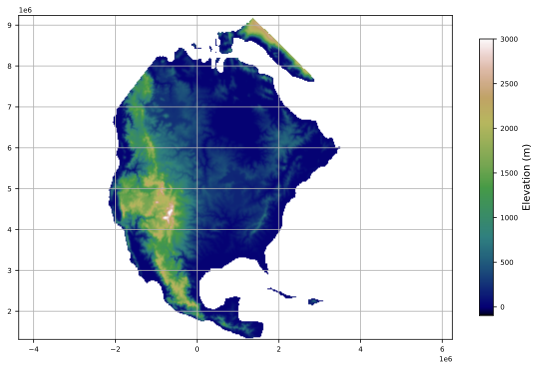

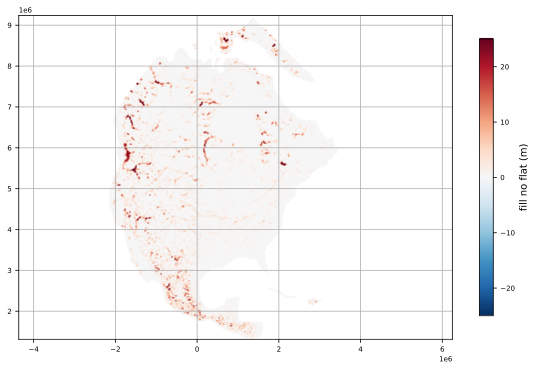

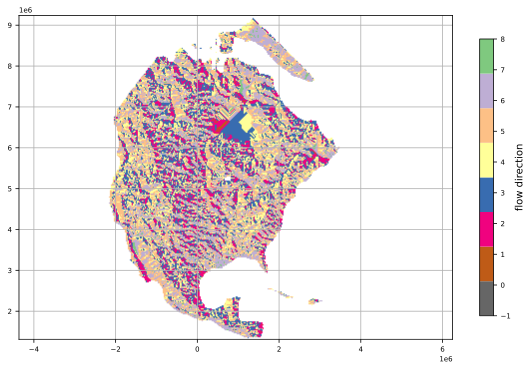

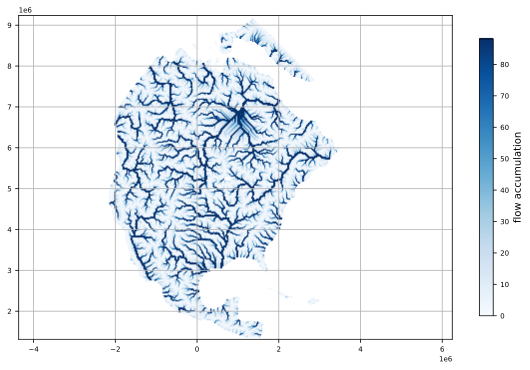

In [9]:
plotraster(grid, dem, -9999, 'Elevation (m)', -100, 3000, 'gist_earth')
plotraster(grid, demnoflat - dem, -9999, 'fill no flat (m)', -25, 25, 'RdBu_r')
plotraster(grid, d8, -9999, 'flow direction', -1, 8, 'Accent_r')
plotraster(grid, flowd8, -9999, 'flow accumulation', 0, np.max(flowd8)/1000, 'Blues')

## Extracting specific outlets

To extract specific catchments, `pysheds` requires the position of the outlet.

Here we show how to extract some specific outlets based on the flow accumulation values. 

:::{note}
The approach here could be automatised to make it easier for the user...
:::

We start by finding the maximum flow accumulation in the entire raster and we will use the corresponding catchment for our analyse.

In [10]:
# Find the point ID corresponding to the maximum flow accumulation value
outletID = np.where(flowd8.flatten() == flowd8.max())[0]

# Get the corresponding point coordinate
outletPt = dem.coords[outletID,:][0]

# Define this first outlet by x1,y1
x1, y1 = outletPt[1], outletPt[0]

We now extract a second outlet corrsponding to the biggest river entering the Gulf of Mexico:

In [11]:
# Find the point ID corresponding to the maximum flow accumulation value in the Gulf of Mexico
outletID = np.where(flowd8.flatten() == flowd8[600:800,500:700].max())[0]

# Get the corresponding point coordinate
outletPt = dem.coords[outletID,:][0]

# Define this first outlet by x2,y2
x2, y2 = outletPt[1], outletPt[0]

Let's see where these 2 outlets are:

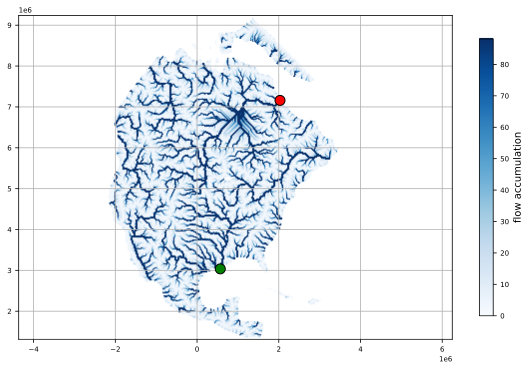

In [12]:
data = np.ma.masked_array(flowd8, mask = (flowd8 <= -9999))
    
plt.figure(figsize=(8,8))
ax = plt.gca()
im = plt.imshow(data, extent=grid.extent, cmap='Blues', vmin=0, vmax=np.max(flowd8)/1000)

plt.plot(x1,y1, 'o', color='r', markersize=10, 
         markeredgecolor='k', markeredgewidth=1)
plt.plot(x2,y2, 'o', color='g', markersize=10, 
         markeredgecolor='k', markeredgewidth=1)

plt.colorbar(im, label='flow accumulation', shrink=0.5)

plt.grid()
plt.tight_layout()
plt.show()

Sounds good!

## Get corresponding catchments

We now define a function `getCatchment` which extract river network (up to a specified flow accumulation `threshold`).

In [13]:
def getCatchment(geotiff, x, y, threshold):
    '''
    Extract a specific river network based on outlet position and flow accumulation threshold.
    '''
    
    grd = Grid.from_raster(geotiff, data_name='dem')

    grd.fill_depressions('dem', out_name='filled',
                          nodata_in = -9999, nodata_out = -9999)
    grd.resolve_flats(data='filled', out_name='inflated_dem')

    dirmap = (3, 2, 1, 8, 7, 6, 5, 4)
    grd.flowdir('inflated_dem', out_name='dir', dirmap=dirmap,
                  nodata_in = -9999, nodata_out = -9999, 
                  pits = -9999, flats = -9999)
    
    grd.accumulation(data='dir', out_name='acc2')

    acc2 = grd.view('acc2', nodata = -9999).astype(np.float32)
    acc2[acc2==0] = -9999
    
    grd.catchment(data='dir', x=x, y=y, out_name='catch',
                    recursionlimit=15000, xytype='label')

    
    grd.clip_to('catch', pad=(1,1,1,1))

    grd.accumulation(data='catch', out_name='acc')
    
    acc = grd.view('acc', nodata = -9999).astype(np.float32)
    acc[acc==0] = -9999
    
    branches = grd.extract_river_network('catch', 'acc', dirmap=dirmap, threshold=threshold, 
                                       nodata_in=-9999, routing='d8',
                                       apply_mask=True)
    
    data = np.ma.masked_array(acc, mask = (acc <= -9999))
    
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    im = plt.imshow(data, extent=grd.extent, cmap='Blues', vmin=0, vmax=np.max(acc)/100)

    plt.plot(x, y, 'o', color='r', markersize=10, markeredgecolor='k', markeredgewidth=1)
    
    plt.colorbar(im, label='flow accumulation', shrink=0.5)

    plt.grid()
    plt.tight_layout()
    plt.show()
    
    tree = spatial.cKDTree(dem.coords, leafsize=10)
    
    branch_df = []
    nbbranches = len(branches['features'])
    
    for b in range(nbbranches):
        branch = branches['features'][b]
        branchXY = np.asarray(branch['geometry']['coordinates'])
        branchXY = np.flip(branchXY,1)
        dist, id = tree.query(branchXY, k=1)
        elev = demnoflat.flatten()[id]
        fa = acc2.flatten()[id]

        data = np.vstack((branchXY[:,0], branchXY[:,1], 
                          elev, fa))
        df = pd.DataFrame(data.T,
                          columns = ['x','y','elev','fa'])
        df = df[df.fa > -9999]
        df = df.reset_index(drop=True)

        xx = df.x.to_numpy()
        yy = df.y.to_numpy()
        dx = xx[1:]-xx[:-1]
        dy = yy[1:]-yy[:-1]
        step_size = np.sqrt(dx**2+dy**2)
        cumulative_distance = np.concatenate(([0], np.cumsum(step_size)))
        df['dist'] = cumulative_distance

        branch_df.append(df)
        
    
    endbranch = None
    maxfa = -10000
    for b in range(nbbranches):
        if branch_df[b].fa[0] > maxfa:
            maxfa = branch_df[b].fa[0]
            endbranch = b
            
    newdf = []
    newdf.append(branch_df[endbranch])
    for b in range(nbbranches):
        if b != endbranch:
            newdf.append(branch_df[b])
        
    return branches, newdf

We call the function for the 2 outlets that were defined previously. The function returns 2 variables:

1. a dictionnary containing the geometry and coordinates of the main rivers
2. a `pandas` dataframe containing for each river the associated flow and elevation information

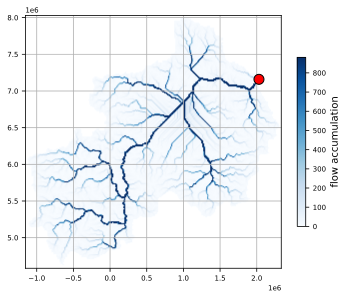

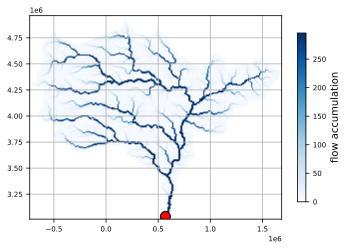

In [14]:
branches1, bdf1 = getCatchment(geotiff='GoMtime5.tif', x=x1, y=y1, threshold=2000)
branches2, bdf2 = getCatchment(geotiff='GoMtime5.tif', x=x2, y=y2, threshold=2000)

### Plotting river networks 

The river networks can be obtained directly from the previous function first variable:

In [15]:
def plotBranch(branchnb):

    plt.figure(figsize=(5,5))
    ax = plt.gca()

    for branch in branchnb['features']:
        line = np.asarray(branch['geometry']['coordinates'])
        plt.plot(line[:, 0], line[:, 1], lw=3)

    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return

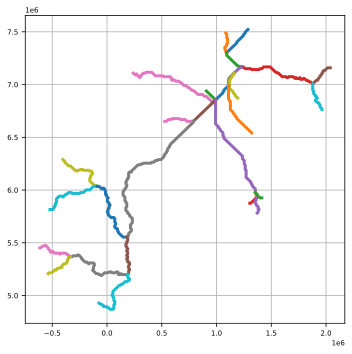

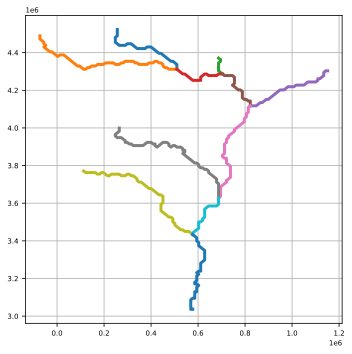

In [16]:
plotBranch(branches1)
plotBranch(branches2)

### Longitudinal profiles

The second variable can be used to extract river longitudinal profile. To do so we define a new function `combineBranch` which connect each individual trunk together:

In [17]:
def combineBranch(branch_df):
    
    check = True
    
    pp = 0
    nbbranches = len(branch_df)
    while(check):
        for b in range(0,nbbranches):
            row1 = branch_df[b].iloc[0]
            x1, y1, dist1 = row1.x, row1.y, row1.dist

            lastrow = np.array(branch_df[b].tail(1))[0]
            xend, yend, distend = lastrow[0], lastrow[1], lastrow[-1]

            for nextb in range(0,nbbranches):
                if nextb != b:
                    firstrow = branch_df[nextb].iloc[0]
                    xstart, ystart, diststart = firstrow.x, firstrow.y, firstrow.dist
                    changed = False
                    if diststart == 0:
                        if abs(xstart-xend) < 1. and abs(ystart-yend) < 1.0:
                            if b == 0:
                                branch_df[nextb].dist += distend
                                changed = True
                            else:
                                if dist1 > 0.:
                                    branch_df[nextb].dist += distend
                                    changed = True
                        if not changed:
                            if abs(xstart-x1) < 1. and abs(ystart-y1) < 1.0:
                                if b == 0:
                                    branch_df[nextb].dist += 0.0001
                                else:
                                    branch_df[nextb].dist += dist1            
        
        check = False
        for b in range(1,nbbranches):
            if branch_df[b].iloc[0].dist == 0.:
                check = True
                
        
    return branch_df

Let's call the above function for each catchment:

In [18]:
ndf1 = combineBranch(branch_df=bdf1)
ndf2 = combineBranch(branch_df=bdf2)

We can now plot the longitudinal profiles:

In [19]:
def plotProfile(dataframe):
    '''
    Function for plotting the longitudinal profile.
    '''

    plt.figure(figsize=(8,4))
    ax = plt.gca()

    for branch in range(len(dataframe)-1,-1,-1):
        distance = np.asarray(dataframe[branch].dist)
        elev = np.asarray(dataframe[branch].elev)

        xnew = np.linspace(distance.min(), distance.max(), 10) 
        spl = make_interp_spline(distance, elev, k=3)  # type: BSpline
        elev_smooth = spl(xnew)

        plt.plot(xnew, elev_smooth, lw=3)

    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return

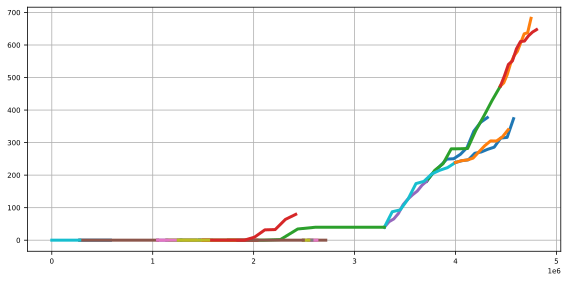

In [22]:
plotProfile(ndf1)

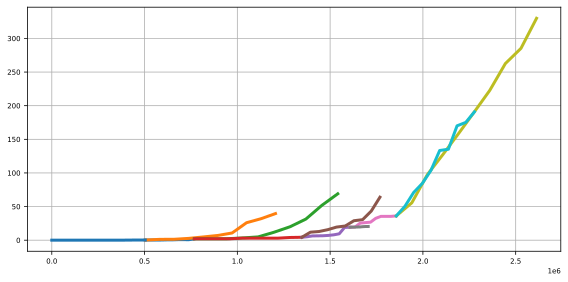

In [23]:
plotProfile(ndf2)